In [355]:
#skysurvey/survey/lsst_comcam.py

import pandas as pd
import numpy as np
from shapely.geometry import box
from skysurvey import Survey
from skysurvey.tools.utils import get_skynoise_from_maglimit
from shapely.ops import unary_union
from skysurvey.effects import mw_extinction
import matplotlib.pyplot as plt
from skysurvey.target import SNeIa, SNeII, SNeIIn, SNeIIb
from skysurvey.lightcurves import get_obsdata
import copy

def from_dp1_parquet(filepath, zp=30.0, exclude_yband=True, fov_arcmin=40.0):
    """
    Construct a skysurvey.Survey from a DP1 visit-level parquet file.

    Parameters
    ----------
    filepath : str
        Path to a `dp1_visits.parquet` file (or filtered version).
    zp : float
        Zeropoint to use in sky noise conversion (default: 30).
    exclude_yband : bool
        If True, excludes 'y' band visits.
    fov_arcmin : float
        Field of view in arcminutes (default: 40 for LSST ComCam).

    Returns
    -------
    survey : skysurvey.Survey
        Survey object usable with skysurvey.
    """
    df = pd.read_parquet(filepath)

    if exclude_yband:
        df = df[df["band"] != "y"]

    simdata = pd.DataFrame({
        "skynoise": df["limitingMagnitude"].apply(get_skynoise_from_maglimit, zp=zp).values,
        "mjd": df["mjd"].values,
        "band": "lsst" + df["band"].values,
        "gain": 1.0,
        "zp": zp,
        "ra": df["ra"].values,
        "dec": df["dec"].values
    }, index=df.index)

    # Construct square footprint (centered on 0,0 in local projection)
    fov_deg = fov_arcmin / 60.0
    half_size = fov_deg / 2.0
    footprint = box(-half_size, -half_size, half_size, half_size)

    return Survey.from_pointings(simdata, footprint=footprint)

def estimate_sn_population_from_parquet(
    parquet_path,
    zp=30.0,
    exclude_yband=True,
    fov_arcmin=40.0,
    zmin=0.0,
    zmax=0.2,
    include_effects=True,
):
    """
    Load a Survey from DP1 parquet and estimate SNeIa population given z-range and footprint.

    Parameters
    ----------
    parquet_path : str
        Path to visit-level parquet.
    zp : float
        Zeropoint for skynoise conversion.
    exclude_yband : bool
        Whether to exclude 'y' band observations.
    fov_arcmin : float
        Field of view size for footprint box.
    zmin, zmax : float
        Redshift bounds for population simulation.
    include_effects : bool
        Whether to apply mw_extinction.

    Returns
    -------
    snia : SNeIa target object
        The simulated population overlapping the footprint.
 
    snii : SNeII target object
    sniin : SNeIIn target object
    sniib : SNeIIb target object
    survey : Survey object

    survey : Survey object
        The loaded survey.
    """
    # Load survey from parquet
    survey = from_dp1_parquet(
        parquet_path,
        zp=zp,
        exclude_yband=exclude_yband,
        fov_arcmin=fov_arcmin,
    )

    # Reconstruct shapely.MultiPolygon skyarea from survey visit centers
    visit_df = pd.read_parquet(parquet_path)
    if exclude_yband:
        visit_df = visit_df[visit_df["band"] != "y"]

    fov_deg = fov_arcmin / 60.0
    half_fov = fov_deg / 2.0
    tiles = []
    for _, row in visit_df.iterrows():
        ra = row["ra"]
        dec = row["dec"]
        tile = box(ra - half_fov, dec - half_fov, ra + half_fov, dec + half_fov)
        tiles.append(tile)
    skyarea = unary_union(tiles)

    # Time range of the survey
    tstart, tstop = survey.get_timerange()

    # Build population with or without extinction
    effects = mw_extinction if include_effects else None
    
    snia = SNeIa.from_draw(
        tstart=tstart,
        tstop=tstop,
        skyarea=skyarea,
        zmin=zmin,
        zmax=zmax,
        effect=effects,
    )

    snii = SNeII.from_draw(
        tstart=tstart,
        tstop=tstop,
        skyarea=skyarea,
        zmin=zmin,
        zmax=zmax,
        effect=effects,
        template='salt2-extended'
    )
    
    return snia, snii, survey



In [357]:
zmin=0.1
zmax=1.0

snia, snii, survey = estimate_sn_population_from_parquet(
    parquet_path,
    zmin=zmin,
    zmax=zmax,
)

  

print(f"Simulated {len(snia.data)} SNeIa between z = {zmin}-{zmax}")
print(f"Simulated {len(snii.data)} SNeII between z = {zmin}-{zmax}")


print(snia.data.head())
survey.data


TypeError: 'Template' object is not iterable

In [ ]:
bands = ["lsstg", "lsstr", "lssti", "lsstz", "lssty"]  # Drop lsstu
dset = dataset.DataSet.from_targets_and_survey(snia, survey, discard_bands=["lsstu"])
dset.data


Index([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 45, 46, 47],
      dtype='int64', name='index')
index  band 
0      lssti     13
       lsstr     17
1      lssti     10
       lsstr     20
3      lssti    102
               ... 
46     lsstg      1
       lssti      2
       lsstr      6
47     lssti      3
       lsstr      5
Length: 80, dtype: int64


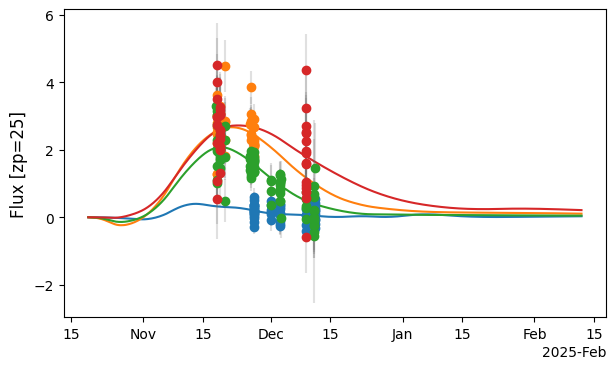

In [335]:
print(dset.obs_index)
print(dset.get_ndetection(per_band=True))
fig = dset.show_target_lightcurve(index=0)

In [337]:

detections = dset.get_data(detection=True)
detections.to_csv("test.csv")
print(np.unique(detections.index.get_level_values(0).to_numpy()))
len(np.unique(detections.index.get_level_values(0).to_numpy()))
# print(detections.fieldid.value_counts())


[ 0  1  3  4  7  8 10 11 12 14 16 18 19 20 21 22 23 25 26 28 30 31 32 33
 35 36 38 39 40 41 42 45 46 47]


34

In [343]:
dset = dataset.DataSet.from_targets_and_survey(snii, survey, discard_bands=["lsstu"])
print(dset.data)




/Users/andradenebula/Documents/Research/Transient_Metrics/Rubin_Data_Preview_SNe/skysurvey-env/lib/python3.12/site-packages/skysurvey/dataset.py:726: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()


ValueError: bandpass 'lsstu' [3105, .., 4086] outside spectral range [3196.92, .., 21910.4]

In [ ]:
import skysurvey
bands = ["lsstg", "lsstr", "lssti", "lsstz", "lssty"]  # Drop lsstu
targets = skysurvey.TargetCollection([snia, snii])
dset = dset.from_targets_and_survey(targets, survey, discard_bands=["lsstu","lsstg"])
dset.data

In [ ]:
def plot_sampled_lightcurves(pop, survey, title=""):
    from sncosmo import Model

    sample_params = pop.data.iloc[:3]
    survey_obs = survey.data.copy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    for i, (ix, params) in enumerate(sample_params.iterrows()):
        ax = axs[i]

        try:
            # ----------- Build model -------------
            if hasattr(pop.template, "sncosmo_model"):  # SNeIa
                base_model = pop.template.sncosmo_model
                model = Model(source=base_model.source)
            elif hasattr(pop.template, "get"):  # SNeII family
                model = pop.template.get(ix)
            else:
                raise ValueError("Unsupported template type")

            # Filter only valid model parameters
            valid_keys = model.param_names
            filtered_params = {k: v for k, v in params.items() if k in valid_keys}
            model.set(**filtered_params)

            # Use only filtered params for get_obsdata
            filtered_df = pd.DataFrame([filtered_params])

            # ----------- Get obsdata and plot -------------
            lc = get_obsdata(model, survey_obs, filtered_df)

            times = np.linspace(params["t0"] - 10, params["t0"] + 60, 300)
            for band in bands:
                try:
                    flux = model.bandflux(band, times, zp=25, zpsys="ab")
                    mag_model = -2.5 * np.log10(np.maximum(flux, 1e-20)) + 25
                    ax.plot(times, mag_model, label=f"{band} model", alpha=0.3)
                except Exception as e:
                    continue


            ax.set_title(f"{title} — Template {ix}")
            ax.set_xlabel("MJD")
            if i == 0:
                ax.set_ylabel("Apparent Magnitude")
            ax.invert_yaxis()
            ax.legend()

        except Exception as e:
            print(f"  Failed for {title} {ix}: {e}")
            continue

    plt.suptitle(f"Survey-Sampled Light Curves — {title}")
    plt.ylim(40, 20)
    plt.tight_layout()
    plt.show()

plot_sampled_lightcurves(snia, survey, title="SNeIa")
plot_sampled_lightcurves(snii, survey, title="SNeII")



In [ ]:
# Load the DP1 visit-level Parquet file

parquet_path = "dp1_visits-ECDFS_EDFS_Fornax_LELF.parquet"  # or your path

# Run and inspect the survey
survey = from_dp1_parquet(parquet_path)

# Show some properties
np.NaN = np.nan  # TEMP FIX for skysurvey compatibility with NumPy 2.0
print(survey)
print(survey.data.head())
print(survey.get_timerange())
survey.show()



In [ ]:

plt.figure(figsize=(8, 6))
plt.scatter(snia.data["ra"], snia.data["dec"], s=3, alpha=0.6)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Simulated LSST-ComCam SNeIa Sky Positions")
plt.grid(True)
plt.show()
